$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Control a Marble with Reinforcement Learning

## Overview

By modifying the reinforcement learning code, we try to solve the dynamic marble problem in this assignment. We will be solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

## Method

The objective for any reinforcement learning problem is to find the sequence of actions that maximizes (or minimizes) the sum
of reinforcements along the sequence. This is reduced to the objective of acquiring the Q function the predicts the expected sum of future reinforcements, because the correct Q function determines the optimal next action.

So, the RL objective is to make this approximation as accuracte as possible:

$$
    \begin{align*}
      Q(s_t,a_t) \approx \sum_{k=0}^\infty r_{t+k+1}
    \end{align*}
$$

This is usually formulated as the least squares objective

$$
    \begin{align*}
      \text{Minimize } \mathrm{E} \left ( \sum_{k=0}^\infty r_{t+k+1} - Q(s_t,a_t)\right )^2
    \end{align*}
$$

Sources of randomness:

   * action selection
   * state transitions
   * reinforcement received

The key problem is that we don't know $\sum_{k=0}^\infty r_{t+k+1}$. 

So we approximate it by 

$$
    \begin{align*}
      \sum_{k=0}^\infty r_{t+k+1}  = & r_{t+1} + \sum_{k=1}^\infty r_{t+k+1}\\
       = & r_{t+1} + \sum_{k=0}^\infty r_{t+1+k+1}\\
       \approx & r_{t+1} + Q(s_{t+1},a_{t+1})
    \end{align*}
$$


Citation : [Reinforcement Learning](http://nbviewer.jupyter.org/url/www.cs.colostate.edu/~anderson/cs480/notebooks/22%20Reinforcement%20Learning%20with%20Neural%20Network%20as%20Q%20Function.ipynb)

## Code

We will be using the following python files to solve the problem

* `marble.py`
* `neuralnetworksbylayer.py`
* `layers.py`
* `scaledconjugategradient.py`
* `mlutils.py`

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy
import math

%matplotlib inline

To define a reinforcement learning problem, we define 4 functions that return

* initial the state of the environment,
* a next state given a current state and an action,
* a reinforcement value, and
* an action to take, given the current state. For this we define an $\epsilon$-greedy policy.

Let's first define these 4 methods. For our simple one-dimensional marble problem, we can push left, right, or not push at all.

To implement the marble problem with the specified goal value, the initialState() method is modified to return a random integer in the range 0-9. 
We also modify the next state method so that it returns the same goal which was in the previous state. 

In [2]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()), math.floor(10*np.random.random_sample())])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity, s[2] is goal. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    #s[2] = s[2] 
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0,s[2]]) #setting the same goal in the new state
    elif s[0] > 10:
        s = np.array([10,0,s[2]])#setting the same goal in the new state
    return s

def reinforcement(s, goal):  # s is new state
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now to generate a bunch of samples that are interactions with the marble, we use the following makeSamples() method.

In [3]:
def makeSamples(qnet, nStepsPerStart,epsilon): #epsilon is added as an additional parameter
    samples = []
    state = initialState()
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState, newState[2])
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples),newState[2] # return goal as well

Using the following method, we can plot the status of the game.

In [4]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace,goal):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [5,5],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,goal,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial,goal):
    xs = np.linspace(0,10,nTrials)
    plt.subplot(4,3,12)
    for x in xs:
        s = [x,0,goal] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

To plot the results for each of the test cases, the following displayResults method is used so that we dont have to repeat the statements again each time.

Let us know experiment on the code using different input values.

In [5]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1]) 
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1), (1,9)))



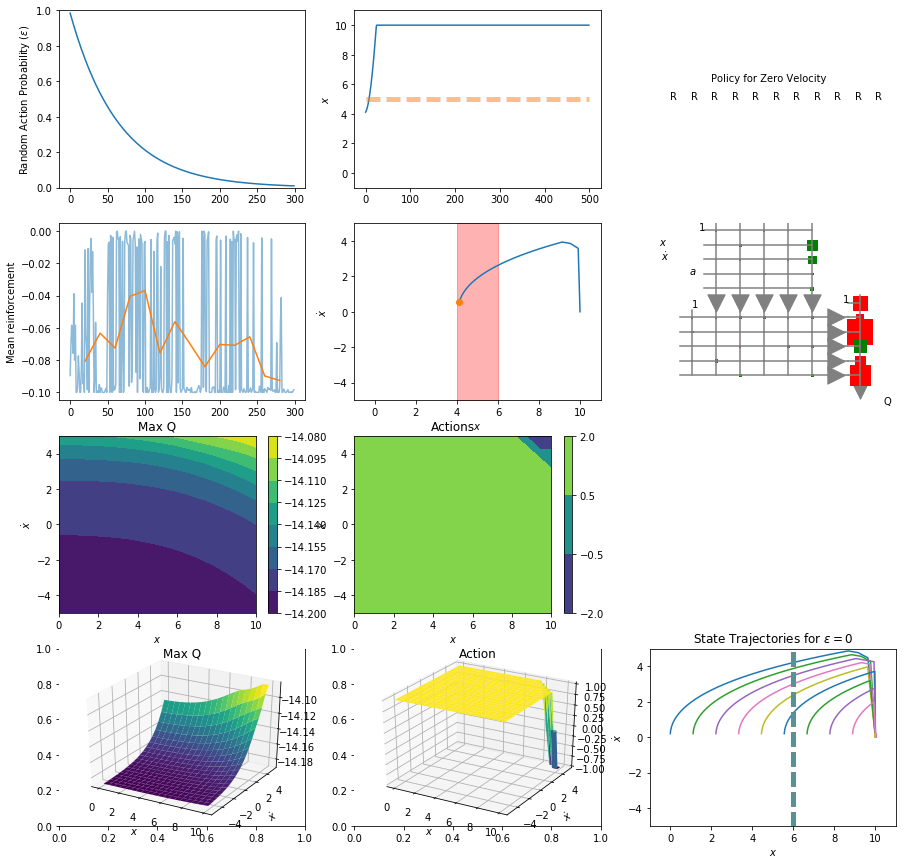

In [6]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples, goal = makeSamples(qnet, nStepsPerTrial,epsilon)
    ns = 3
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    #print(nextX.shape,ns+na+1)
    nextQ = qnet.use(nextX)
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    #print(epsilon)
    rtrace[trial] = np.mean(R)
    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,100,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

        # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

Above are the results obtained with a NeuralNetwork of 2 layers of 5 units each and trained with nSCGIterations=30. Let's now try to experiment with different values.

To display the results for 1,5,9, let us write a method to display results

In [8]:
def displayResults(qnet,nStepsPerTrial,nTrials,gamma,nSCGIterations,epsilonDecay):
    fig = plt.figure(figsize=(15,15))

    epsilon = 1
    epsilonTrace = np.zeros(nTrials)
    rtrace = np.zeros(nTrials)
    
    for trial in range(nTrials):

        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        samples, goal = makeSamples(qnet, nStepsPerTrial,epsilon)

        ns = 3
        na = 1
        X = samples[:, :ns+na]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        #print(nextX.shape,ns+na+1)
        nextQ = qnet.use(nextX)

        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        #print(epsilon)
        rtrace[trial] = np.mean(R)

        if trial % (nTrials//10) == 0 or trial == nTrials-1:
            if goal in [1,5,9]:
                plt.clf()
                plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
                testIt(qnet,10,500,goal)
                #clear_output(wait=True)
                display(fig);
                plt.pause(0.01)

        # print('Trial',trial,'mean R',np.mean(R))
    #clear_output(wait=True)

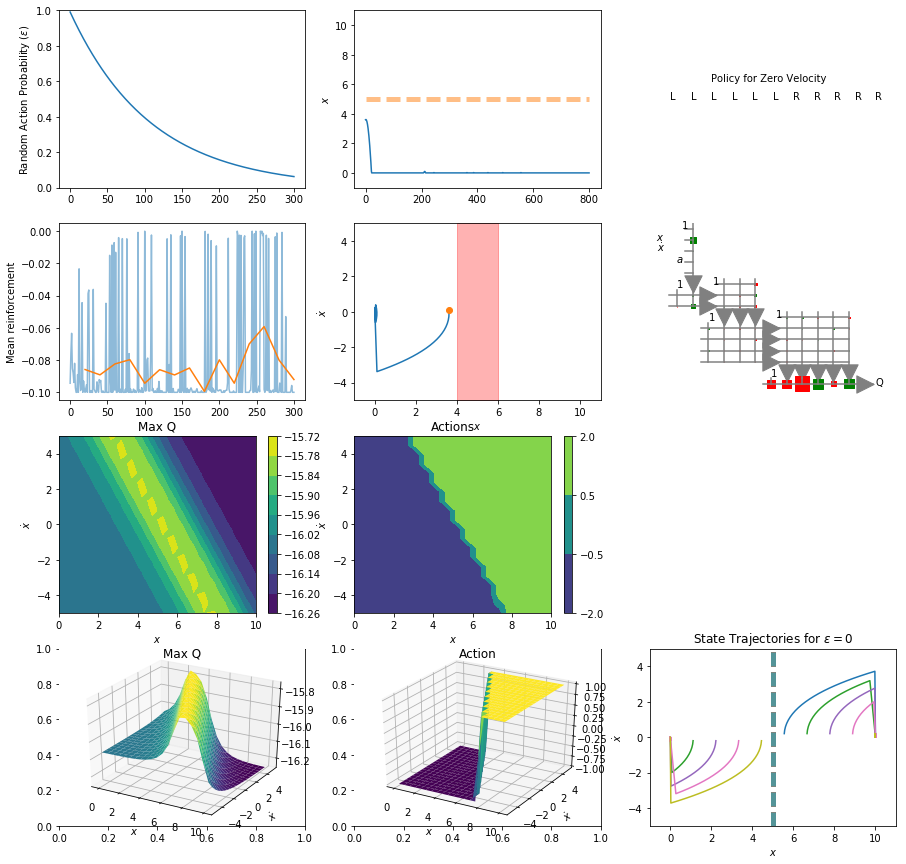

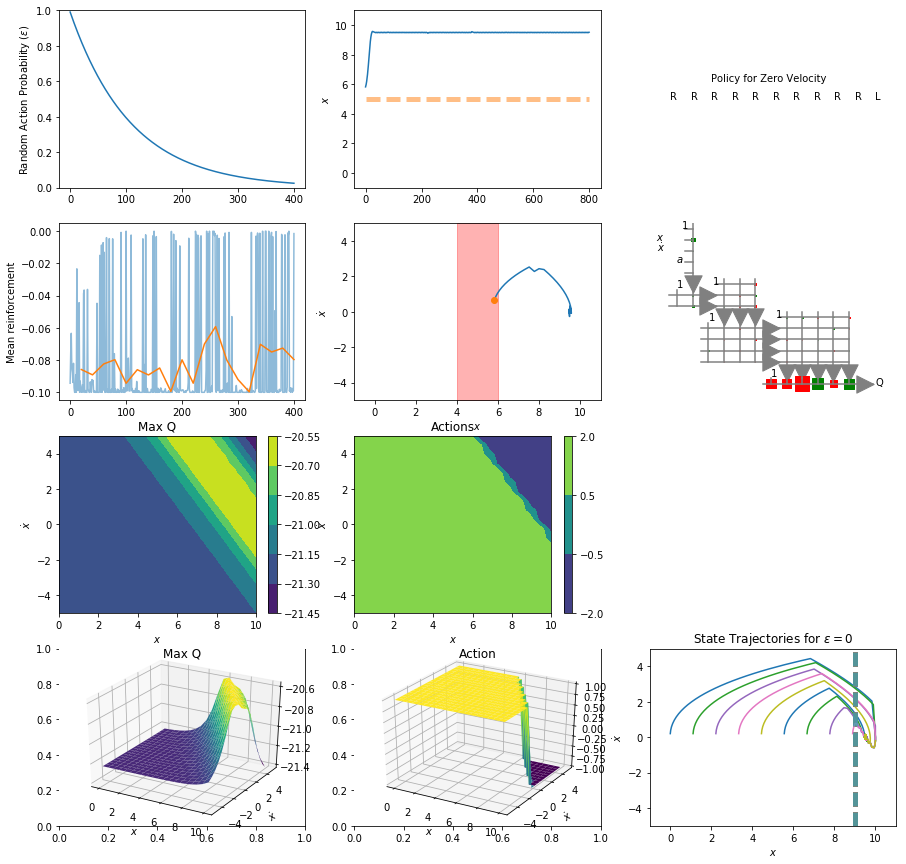

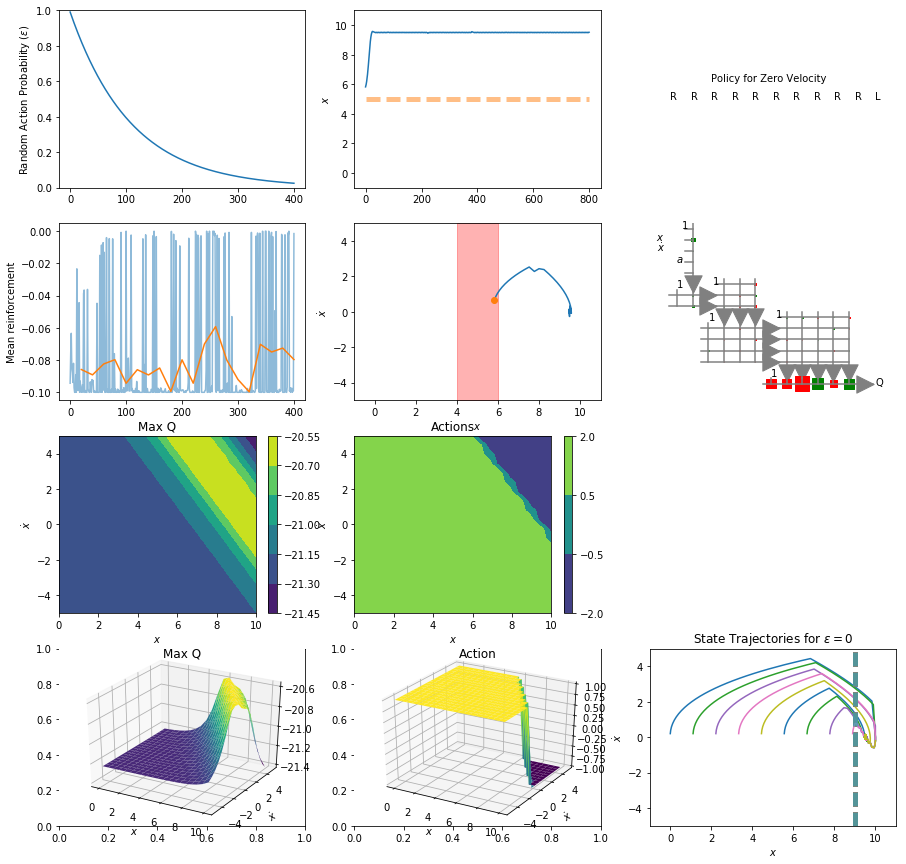

In [9]:
gamma = 0.999
nTrials = 500
nStepsPerTrial = 800 
nSCGIterations = 100
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))

nh = [1,2,3,4,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 10, 10, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1), (1,9)))

displayResults(qnet,nStepsPerTrial,nTrials,gamma,nSCGIterations,epsilonDecay)

The above results do not seem to be good. Let's experiment with some other set of inputs

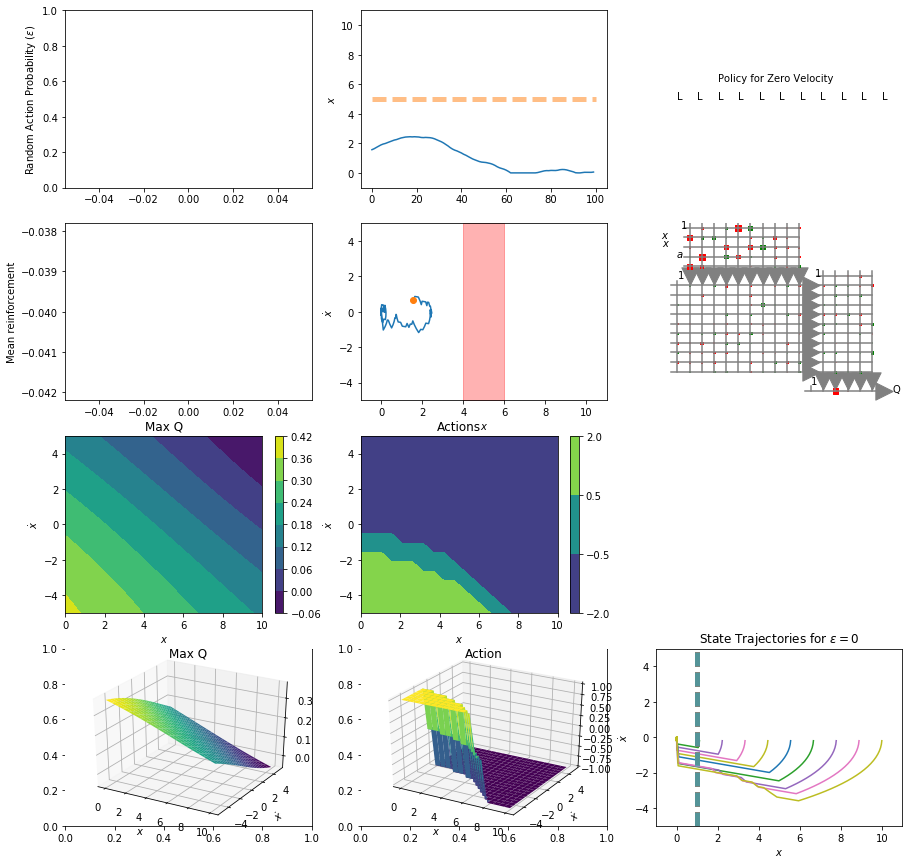

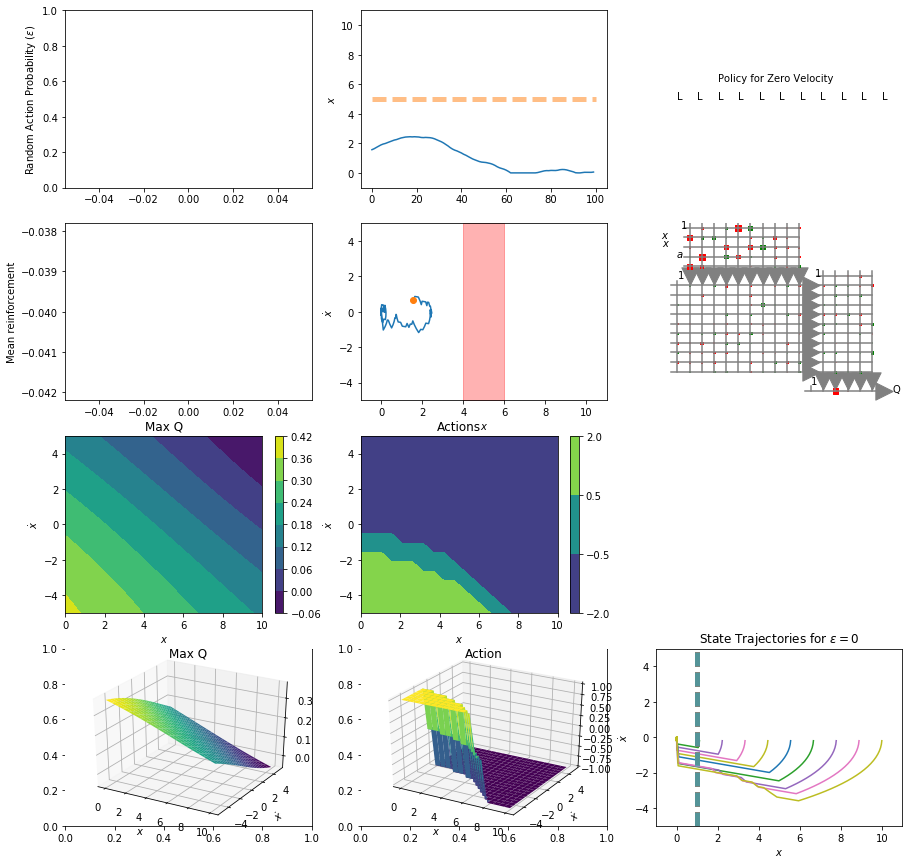

In [10]:
gamma = 0.999
nTrials = 500
nStepsPerTrial = 100 
nSCGIterations = 50
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))

nh = [10,10,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 10, 10, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1), (1,9)))

displayResults(qnet,nStepsPerTrial,nTrials,gamma,nSCGIterations,epsilonDecay)

The results now obtained are not as good the previous results also. The points are completely off from the center

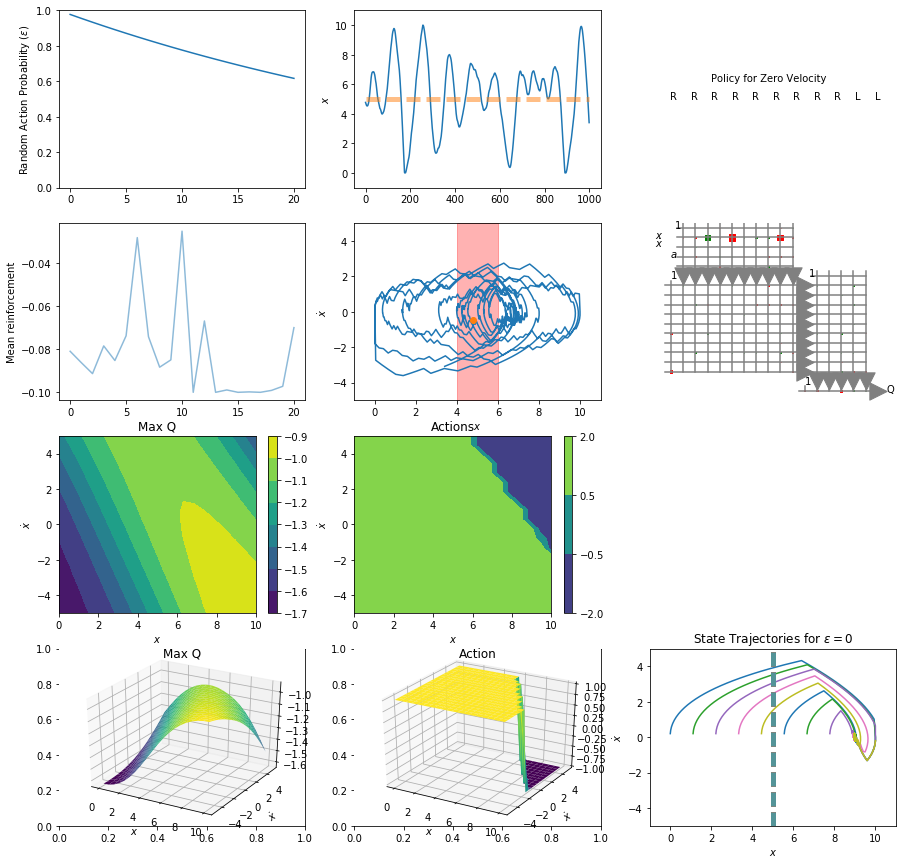

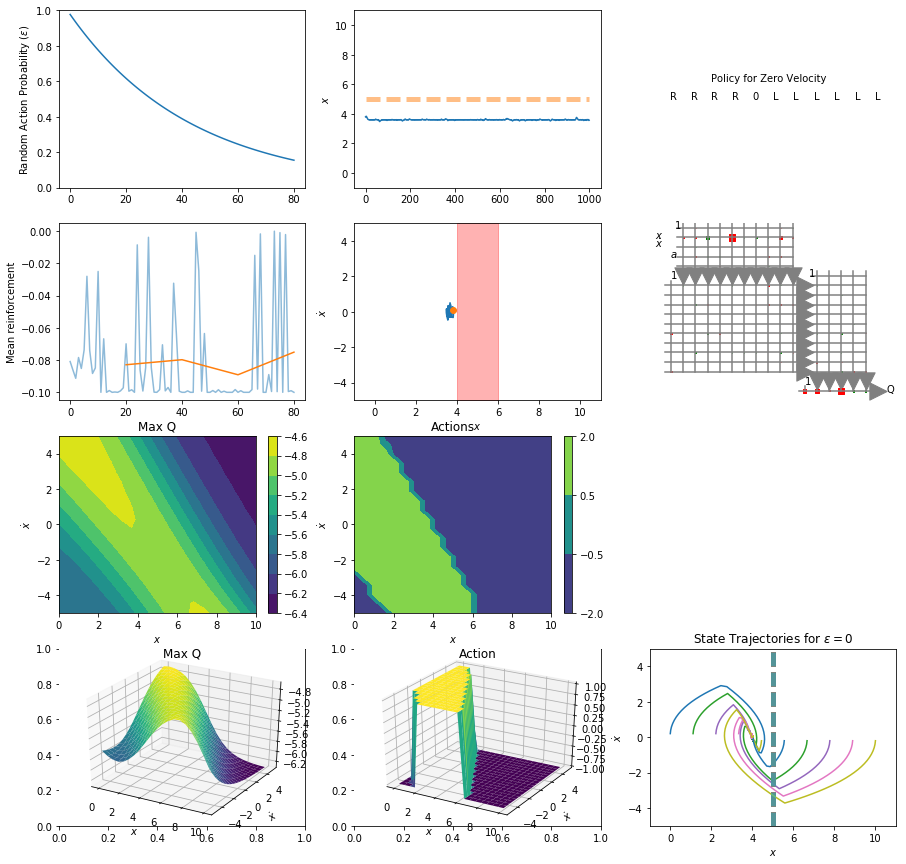

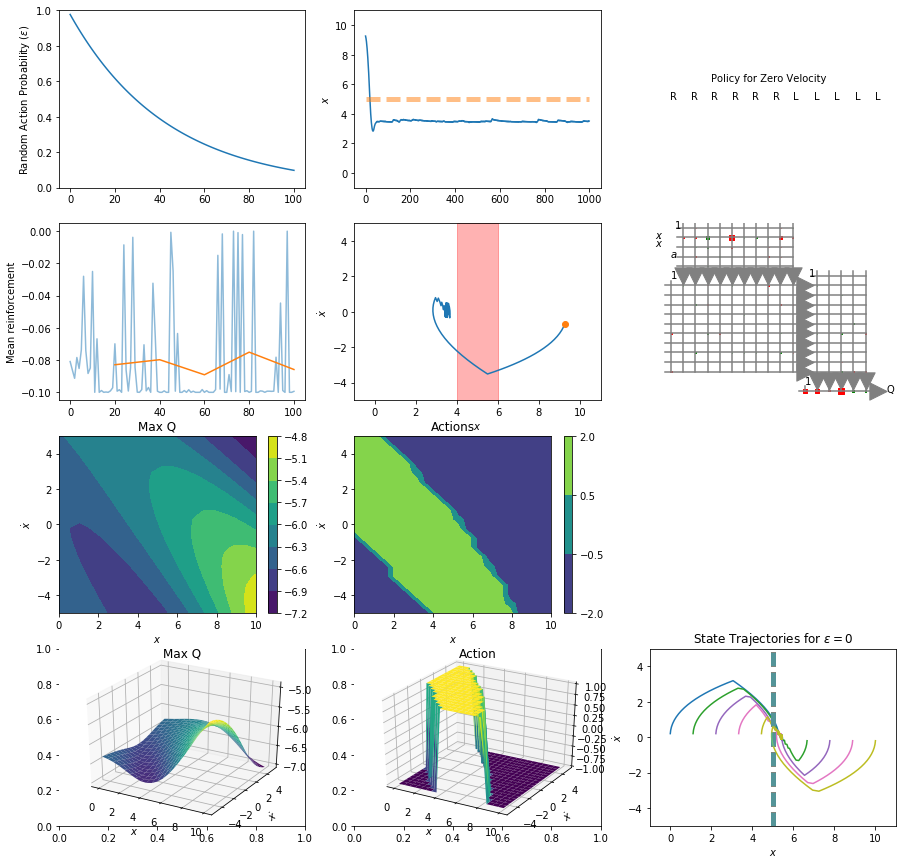

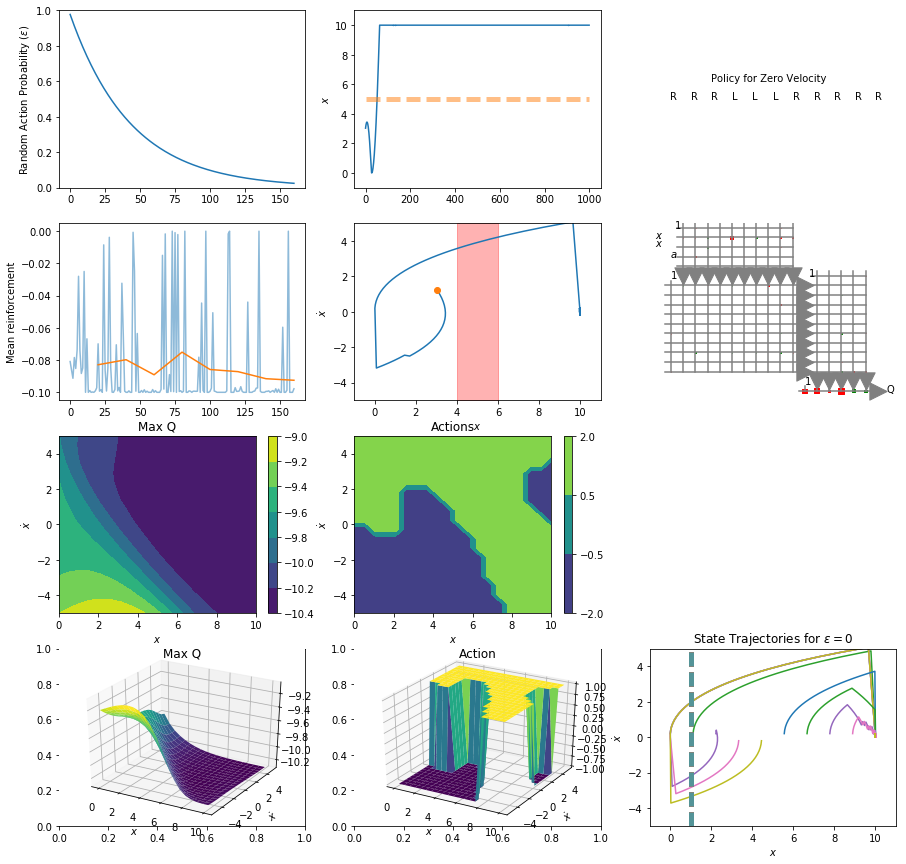

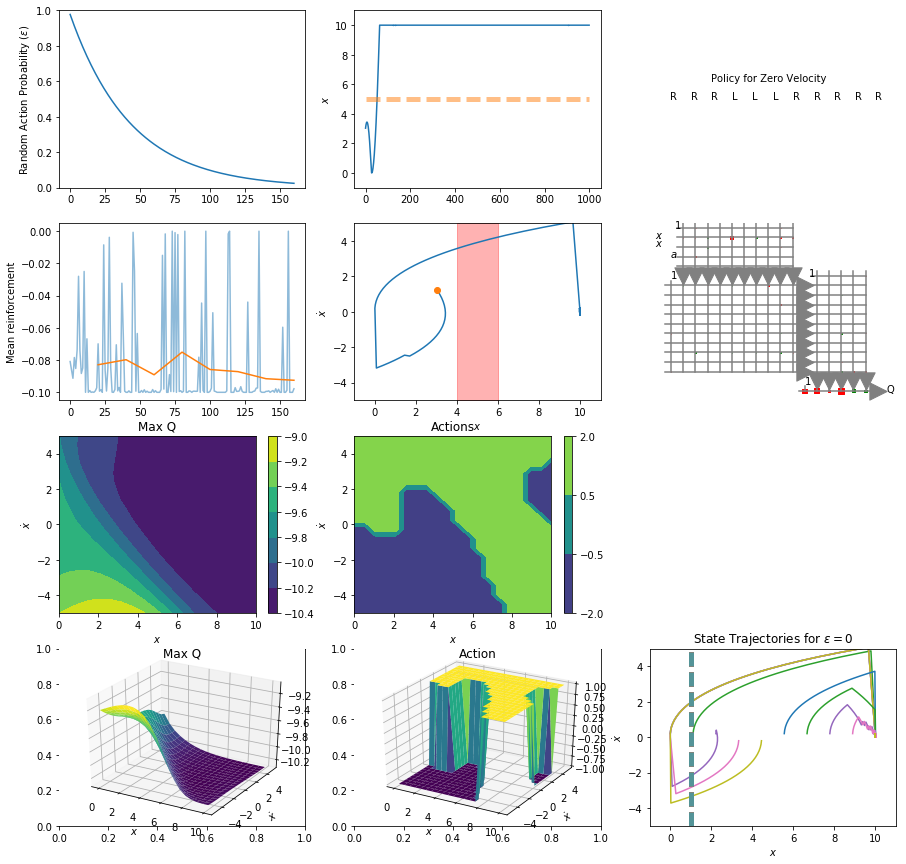

In [11]:
gamma = 0.999
nTrials = 200
nStepsPerTrial = 1000 
nSCGIterations = 100
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))

nh = [10,10,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 10, 10, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1), (1,9)))

displayResults(qnet,nStepsPerTrial,nTrials,gamma,nSCGIterations,epsilonDecay)

These results seem to be better. Let's now try to increase the nStepsPerTrial and also the nSCGIterations values. 

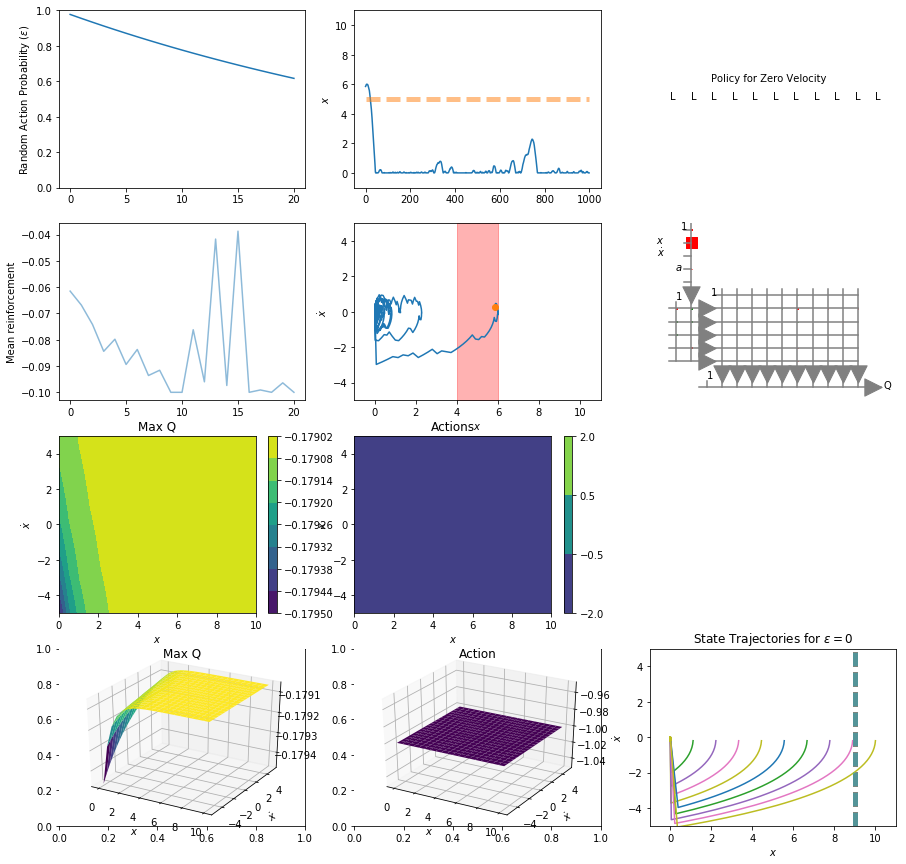

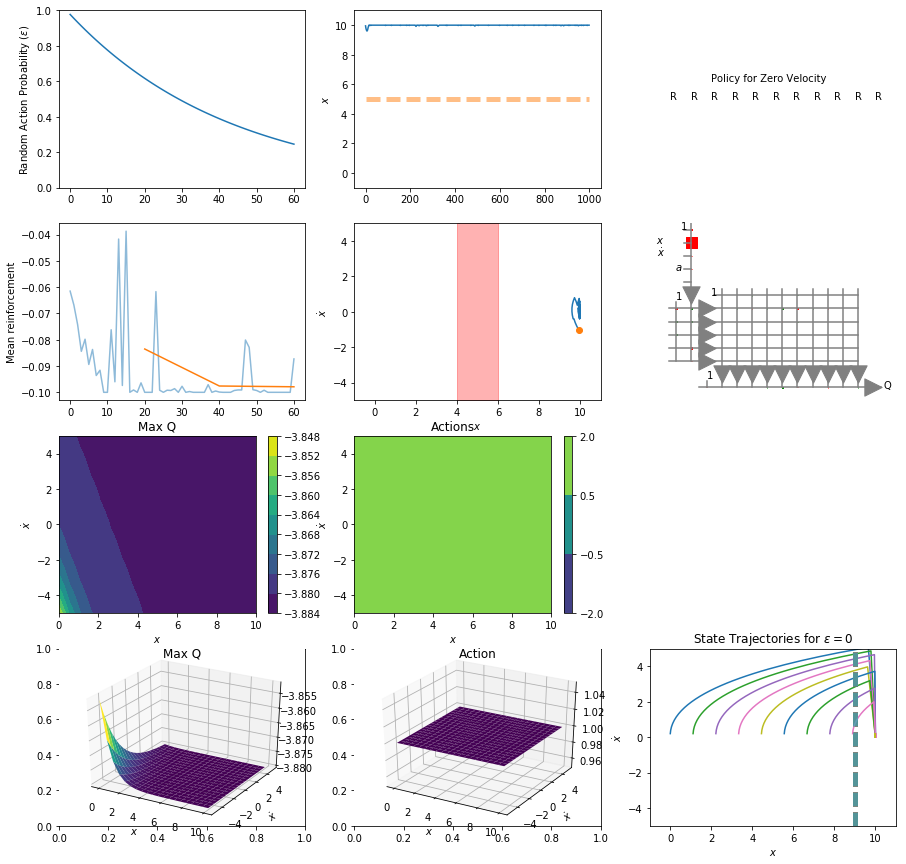

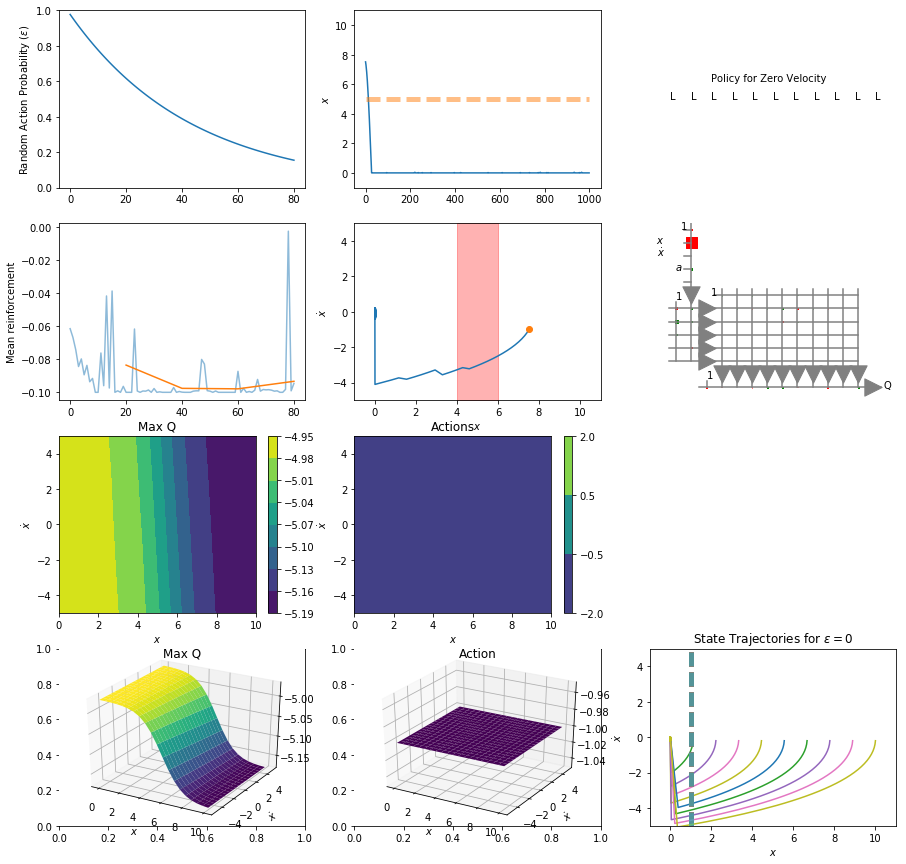

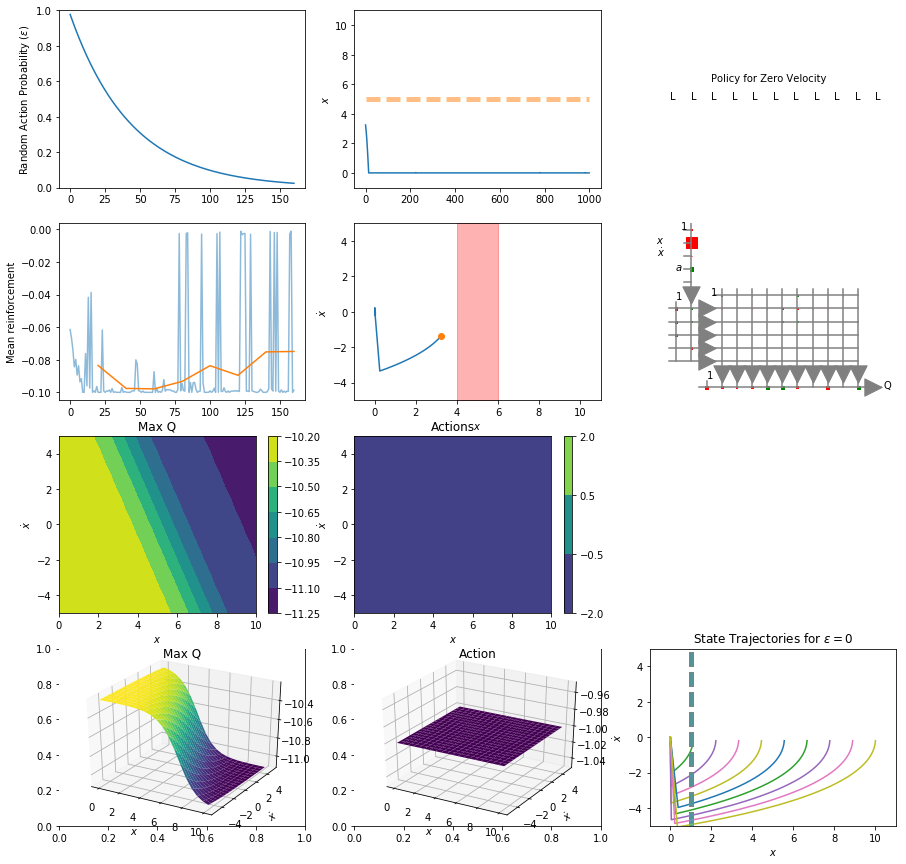

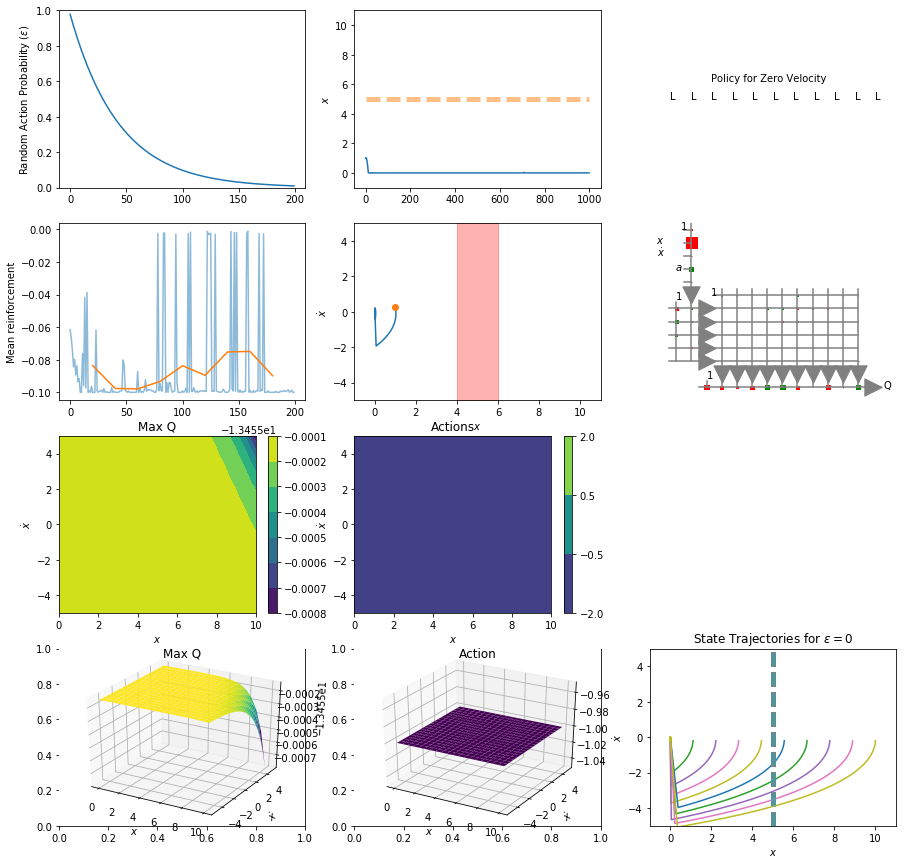

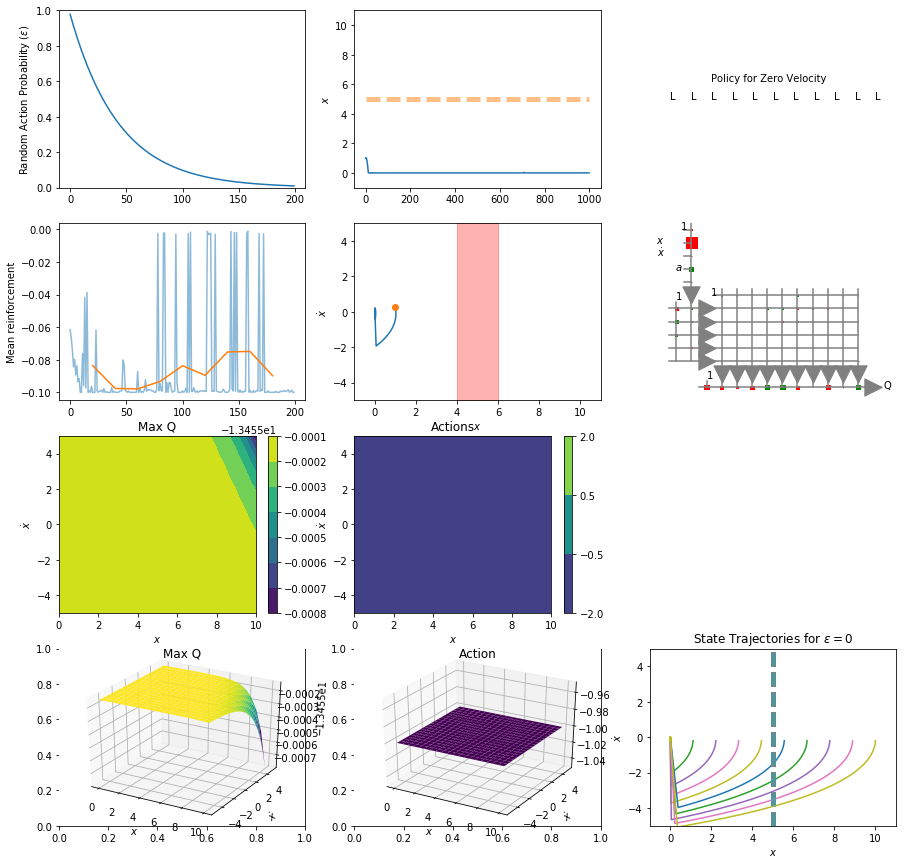

In [13]:
gamma = 0.999
nTrials = 200
nStepsPerTrial = 1000 
nSCGIterations = 100
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))

nh = [1,5,10]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 10, 10, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1), (1,9)))

displayResults(qnet,nStepsPerTrial,nTrials,gamma,nSCGIterations,epsilonDecay)

Thus from the above plots we can see that the network with 5 layers and values 1,2,3,4,5 give better results.

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$